In [1]:
import tensorflow as tf
import tensorflow.keras as tfk

from tensorflow.keras.preprocessing import image as tfk_image
from tensorflow.keras.preprocessing.image import ImageDataGenerator as tfk_ImageDataGenerator

import datetime, os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set();
from PIL import Image

from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, log_loss, accuracy_score
from sklearn.preprocessing import OneHotEncoder

EPS = 1e-9

In [2]:
from tensorflow.python.keras.applications.efficientnet import EfficientNetB7 as tfk_BaseModel
from tensorflow.python.keras.applications.efficientnet import preprocess_input as tfk_preprocess_input

## Load Dataset

In [3]:
pd_train = pd.read_csv('shopee-product-detection-dataset/train.csv').sort_values(by=['filename'])
pd_test  = pd.read_csv('shopee-product-detection-dataset/test.csv').sort_values(by=['filename'])

In [4]:
input_shape = (256, 256, 3)
# input_shape = (512, 512, 3)
batch_size=128

In [5]:
train_datagen = tfk_ImageDataGenerator(
    preprocessing_function=tfk_preprocess_input,
    validation_split=0.1,
    #featurewise_center=True,
    #featurewise_std_normalization=True,
    rotation_range=45,
    shear_range=20,
    zoom_range=[0.9, 1.1],
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

train_generator = train_datagen.flow_from_directory(
    'shopee-product-detection-dataset/train/',  # this is where you specify the path to the train data folder
    target_size=input_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    'shopee-product-detection-dataset/train/',  # this is where you specify the path to the train data folder
    target_size=input_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='validation'
)

Found 94869 images belonging to 42 classes.
Found 10523 images belonging to 42 classes.


In [6]:
test_datagen = tfk_ImageDataGenerator(
    preprocessing_function=tfk_preprocess_input
)

test_generator = test_datagen.flow_from_dataframe(
    pd_test,
    directory='shopee-product-detection-dataset/test/',
    x_col='filename',
    y_col='category',
    target_size=input_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='raw',
    shuffle=True,
)

Found 12186 validated image filenames.


In [7]:
# x,y = next(iter(test_generator))

## Prepare model

In [8]:
base_model = tfk_BaseModel(input_shape=input_shape, weights='imagenet', include_top=False)
len(base_model.layers)

813

In [9]:
for layer in base_model.layers[:-16]:
  layer.trainable = False

In [10]:
model = tfk.Sequential([
    base_model,
    tfk.layers.GlobalMaxPooling2D(),
    tfk.layers.Dense(512, activation='relu'),
    #tfk.layers.Dense(256, activation='relu'),
    tfk.layers.Dense(128, activation='relu'),
    tfk.layers.Dense(42, activation='softmax', name='output_layer'),
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Model)       (None, 8, 8, 2560)        64097687  
_________________________________________________________________
global_max_pooling2d (Global (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1311232   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
output_layer (Dense)         (None, 42)                5418      
Total params: 65,480,001
Trainable params: 6,759,754
Non-trainable params: 58,720,247
_________________________________________________________________


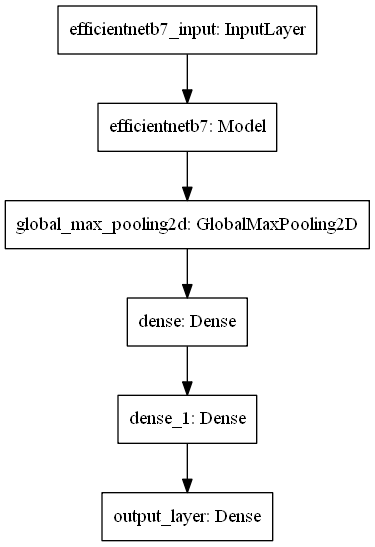

In [12]:
tfk.utils.plot_model(model)

In [42]:
model.compile(optimizer=tfk.optimizers.Adam(learning_rate=1e-5),
              loss=tfk.losses.CategoricalCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])

## Train Model

In [8]:
model = tfk.models.load_model('.model_files/saves/model_5.h5')

In [9]:
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(train_generator.classes),
                                                  train_generator.classes)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

train_step_size = train_generator.n//train_generator.batch_size
val_step_size   = val_generator.n//val_generator.batch_size
print(train_step_size, val_step_size)

741 82


In [44]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.2,
    patience=5,
    min_lr=1e-7
)

early_stop = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    restore_best_weights=True
)

checkpoint_dir = os.path.join('.model_files')
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
checkpoint = tfk.callbacks.ModelCheckpoint(
    filepath = checkpoint_dir + '/ckpt/',
    save_freq ='epoch',
    save_best_only=True
)

log_dir = os.path.join(".model_files/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    update_freq=100,
    profile_batch = 100000000
)

In [45]:
history = model.fit(train_generator,
                    initial_epoch=74,
                    epochs=100,
                    steps_per_epoch=200,
                    validation_steps=20,
                    validation_data=val_generator,
                    class_weight=class_weights,
                    callbacks=[reduce_lr,
                              early_stop, 
                              checkpoint, 
                              tensorboard_callback
                              ]
                   )

Epoch 75/100
200/200 [==============================] - 863s 4s/step - loss: 1.3116 - accuracy: 0.7876 - val_loss: 1.4584 - val_accuracy: 0.7531 - lr: 1.0000e-05
Epoch 76/100
200/200 [==============================] - 820s 4s/step - loss: 1.3194 - accuracy: 0.7832 - val_loss: 1.4416 - val_accuracy: 0.7625 - lr: 1.0000e-05
Epoch 77/100
200/200 [==============================] - 801s 4s/step - loss: 1.3097 - accuracy: 0.7858 - val_loss: 1.4463 - val_accuracy: 0.7576 - lr: 1.0000e-05
Epoch 78/100
200/200 [==============================] - 900s 4s/step - loss: 1.3048 - accuracy: 0.7890 - val_loss: 1.4330 - val_accuracy: 0.7625 - lr: 1.0000e-05
Epoch 79/100
200/200 [==============================] - 927s 5s/step - loss: 1.3037 - accuracy: 0.7907 - val_loss: 1.4581 - val_accuracy: 0.7543 - lr: 1.0000e-05
Epoch 80/100
200/200 [==============================] - 857s 4s/step - loss: 1.3108 - accuracy: 0.7871 - val_loss: 1.4504 - val_accuracy: 0.7539 - lr: 1.0000e-05
Epoch 81/100
200/200 [======

KeyboardInterrupt: 

In [46]:
model.save('model_5.h5')

## Testing

In [8]:
model = tfk.models.load_model('.model_files/saves/model_1.h5')

In [9]:
pd_train_clean = pd.read_csv('shopee-product-detection-dataset/train.csv').sort_values(by=['filename'])
pd_train_clean['dir_filename'] = pd_train_clean.apply(lambda x: '{:02d}/{}'.format(x.category, x.filename), axis=1)
pd_train_clean['category'] = pd_train_clean['category'].apply(lambda x : '{:02d}'.format(x))
pd_train_clean.head()

,filename,category,dir_filename
30694,0000ffaa6ce77e3dde38bcefa039a4a4.jpg,16,16/0000ffaa6ce77e3dde38bcefa039a4a4.jpg
50947,00017f8bf9d8a34dab8f9707a378dbe5.jpg,38,38/00017f8bf9d8a34dab8f9707a378dbe5.jpg
31622,00022314f9c58eb20d248ed239db3a52.jpg,16,16/00022314f9c58eb20d248ed239db3a52.jpg
34234,0002d098348d8358c44032903e117ade.jpg,28,28/0002d098348d8358c44032903e117ade.jpg
12787,000367a6ec58e9d1e4bc340d8d871dab.jpg,34,34/000367a6ec58e9d1e4bc340d8d871dab.jpg


In [10]:
clean_datagen = tfk_ImageDataGenerator(
    preprocessing_function=tfk_preprocess_input,
)

clean_generator = clean_datagen.flow_from_dataframe(
    pd_train_clean,
    directory='shopee-product-detection-dataset/train/',
    x_col='dir_filename',
    y_col='category',
    target_size=input_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
)

Found 105392 validated image filenames belonging to 42 classes.


In [11]:
%%time
y_pred = []
y_true = []

for i in range(50):
    if (i+1) % 10 == 0:
        print("step:", i+1)
    x, y = next(iter(val_generator))
    y_true.extend(y)
    y_pred.extend(model.predict(x))

y_pred = np.array(y_pred)
y_true = np.array(y_true)

step: 10
step: 20
step: 30
step: 40
step: 50
Wall time: 1min 52s


In [12]:
matrix = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))

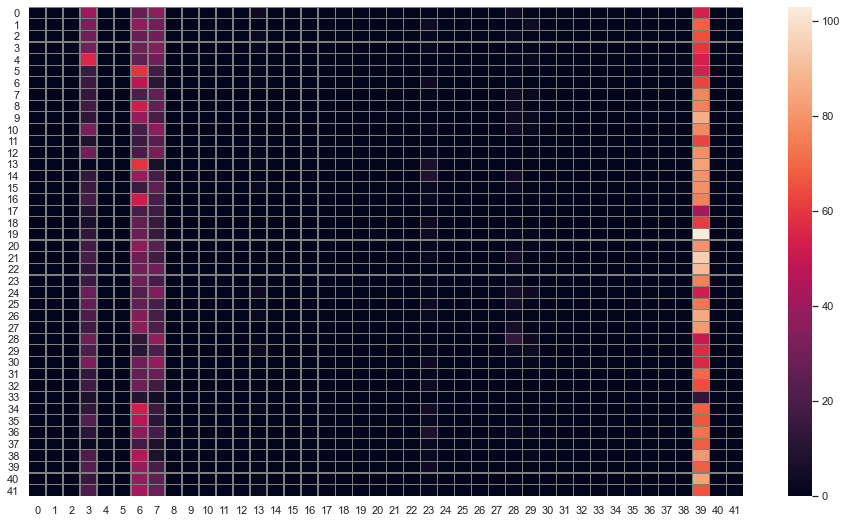

In [13]:
plt.figure(figsize = (16,9))
sns.heatmap(matrix, linecolor='grey', linewidth=0.1)
plt.savefig('confusion_matrix.png', 
            #transparent=True,
            bbox_inches='tight')

In [14]:
def label_smoother(x, factor=0.1):
    xx = x.copy()
    xx[x == 1] = 1 - factor
    xx[x == 0] = factor / (y_true.shape[1] - 1)
    return xx

In [15]:
loss     = tfk.losses.categorical_crossentropy(y_pred, label_smoother(y_true)).numpy().mean()
accuracy = accuracy_score(y_pred.argmax(axis=1), y_true.argmax(axis=1))

print("Loss:", loss)
print("Accuracy:", accuracy)

Loss: 5.8365355
Accuracy: 0.03046875


## Data Cleaning

In [10]:
pd_train.head()

,filename,category
30694,0000ffaa6ce77e3dde38bcefa039a4a4.jpg,16
50947,00017f8bf9d8a34dab8f9707a378dbe5.jpg,38
31622,00022314f9c58eb20d248ed239db3a52.jpg,16
34234,0002d098348d8358c44032903e117ade.jpg,28
12787,000367a6ec58e9d1e4bc340d8d871dab.jpg,34


In [11]:
def calc_category_losses(category_i):
    pd_cat_i = pd_train[pd_train['category'] == category_i]
    pd_cat_i = pd_cat_i.sort_values(by=['filename'])
    
    cat_i_datagen = tfk_ImageDataGenerator(
        preprocessing_function=tfk_preprocess_input
    )

    cat_i_generator = cat_i_datagen.flow_from_dataframe(
        pd_cat_i,
        directory='shopee-product-detection-dataset/train/{:02d}'.format(category_i),
        x_col='filename',
        y_col='category',
        target_size=input_shape[:2],
        color_mode='rgb',
        batch_size=batch_size,
        class_mode='raw',
        shuffle=False,
    )
    
    y_pred_i = model.predict(cat_i_generator, verbose=1, steps=len(cat_i_generator.labels)//batch_size+1)
    y_pred_i = y_pred_i[:len(cat_i_generator.labels)]
    
    y_true_i = np.full((len(cat_i_generator.labels), 42), 0.1/41, dtype='float')
    y_true_i[:,category_i] = 0.9
    
    cce = tfk.losses.CategoricalCrossentropy(reduction=tfk.losses.Reduction.NONE)
    losses = cce(y_pred_i, y_true_i).numpy()
    return pd_cat_i, y_pred_i, losses

In [ ]:
pd_train_losses = []
for i in range(42):
    pd_cat_i, y_pred_i, losses = calc_category_losses(i)
    pd_cat_i['predicted_category'] = y_pred_i.argmax(axis=1)
    pd_cat_i['loss'] = losses
    pd_train_losses.append(pd_cat_i)
pd_train_losses = pd.concat(pd_train_losses, ignore_index=True)

In [82]:
pd_train_losses = pd_train_losses.sort_values(by=['loss'], ascending=False)
pd_train_losses = pd_train_losses.reset_index().drop('index', axis=1)
pd_train_losses['mistake'] = 1*(pd_train_losses['category'] != pd_train_losses['predicted_category'])
pd_train_losses['cum_mistakes'] = pd_train_losses['mistake'].cumsum()
pd_train_losses.head()

,filename,category,predicted_category,loss,cum_mistakes,mistake
0,16f9a736b9bbccc55447ee55019c5912.jpg,12,26,6.015628,1,1
1,a26df05f3d18d5dbb4027707d3a81168.jpg,4,29,6.014174,2,1
2,75f6d645f06733d735d642446c135076.jpg,0,4,6.013391,3,1
3,0d6481d48dfa9689ef6aa020cd9e5b94.jpg,29,4,6.013052,4,1
4,011ef33346d01259f627b44bc5060584.jpg,41,22,6.012937,5,1


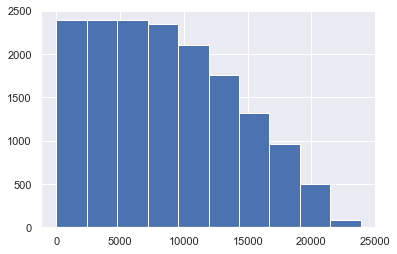

In [88]:
plt.hist(pd_train_losses[pd_train_losses['mistake'] == 1].index);

In [131]:
num_mistakes   = pd_train_losses['cum_mistakes'].max()
mistakes_ratio = 1.0

In [132]:
pd_confusing_images = pd_train_losses[pd_train_losses['cum_mistakes'] <= num_mistakes*mistakes_ratio-EPS]
pd_confusing_images = pd_confusing_images.drop(['cum_mistakes', 'mistake'], axis=1)
pd_confusing_images.tail(10)

,filename,category,predicted_category,loss
23867,2b4e38b1276d74ec78ed07e48f43b0a0.jpg,38,38,3.188401
23868,03a368b5e2a9520cb13547f888544190.jpg,1,1,3.188327
23869,1ef0c3aea58a39299b999c7a3193bd3c.jpg,1,1,3.187934
23870,fa84c252694018edd44d751d1c5e649f.jpg,11,11,3.187856
23871,ca3f914c7a019fc0477426c4d8b3e351.jpg,24,24,3.187367
23872,d4672a0e7a79d464a7c90fa2218a1132.jpg,9,9,3.187084
23873,92ae03813b87210e4ae49c0099cfb4da.jpg,10,10,3.187005
23874,0e9f5bf576df19b3df5e361cf9462a1c.jpg,41,41,3.186953
23875,b86235e5f4a6a60211ffb6672ac326d4.jpg,8,8,3.186615
23876,97b79043fbeedacb40b4e2aef3f70e1b.jpg,35,35,3.186590


In [133]:
len(pd_confusing_images) / len(pd_train)

0.22655419766206164

In [134]:
pd_confusing_images.to_csv('shopee-product-detection-dataset/confusing_images_2__mistake_ratio={}.csv'.format(mistakes_ratio), index=False)

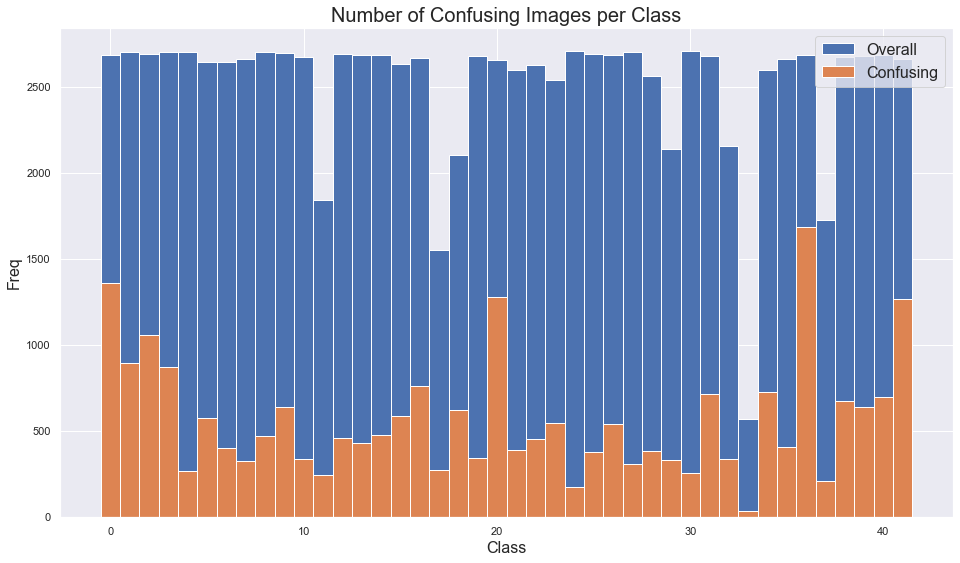

In [135]:
plt.figure(figsize=(16, 9))
plt.title("Number of Confusing Images per Class", fontsize=20)
plt.hist(pd_train['category'], bins=np.arange(43)-0.5, label='Overall')
plt.hist(pd_confusing_images['category'], bins=np.arange(43)-0.5, label='Confusing')
plt.xlabel('Class', fontsize=16)
plt.ylabel('Freq', fontsize=16)
plt.legend(fontsize=16)
plt.savefig('confusion_hist____mistake_ratio={}.png'.format(mistakes_ratio), 
            #transparent=True,
            bbox_inches='tight')
plt.show()

In [140]:
num_mistakes/len(pd_train), num_mistakes*0.1/len(pd_train), num_mistakes*0.05/len(pd_train)

(0.15394906634279643, 0.015394906634279643, 0.007697453317139821)

In [90]:
# def find_confusing_images(LOSS_LIMIT=9):
#     confusing_images = []
#     for i in range(42):
#         pd_cat_i, y_pred_i, losses = calc_category_losses(i)
#         pd_cat_i['predicted_category'] = y_pred_i.argmax(axis=1)
#         pd_cat_i['loss'] = losses
#         
#         pd_weird_i = pd_cat_i[pd_cat_i['loss'] > LOSS_LIMIT].copy().sort_values(by=['loss'], ascending=False)
#         confusing_images.append(pd_weird_i)
#     return pd.concat(confusing_images, ignore_index=True)

In [91]:
# pd_confusing_images = find_confusing_images(LOSS_LIMIT=9)

In [95]:
# n = len(pd_confusing_images)
# print(n)
# 
# pd_confusing_images_raprap = pd_confusing_images.iloc[:n//3].copy()
# pd_confusing_images_ralph  = pd_confusing_images.iloc[n//3:2*(n//3)].copy()
# pd_confusing_images_franz  = pd_confusing_images.iloc[2*(n//3):].copy()
# 
# pd_confusing_images_raprap['correct_category'] = -1
# pd_confusing_images_ralph['correct_category']  = -1
# pd_confusing_images_franz['correct_category']  = -1

In [96]:
# pd_confusing_images_raprap.to_csv('shopee-product-detection-dataset/confusing_images__raprap.csv', index=False)
# pd_confusing_images_ralph.to_csv('shopee-product-detection-dataset/confusing_images__ralph.csv',   index=False)
# pd_confusing_images_franz.to_csv('shopee-product-detection-dataset/confusing_images__franz.csv',   index=False)

In [97]:
# pd_confusing_images_franz.tail(20)

## Generate Submission

In [141]:
pd_test = pd.read_csv('shopee-product-detection-dataset/test.csv').sort_values(by=['filename'])
pd_test.head()

,filename,category
485,0004b03ad7eabfb3989727c461310a84.jpg,43
6397,0004d34271d0a0253f8a95d0746bae05.jpg,43
2181,000d4ad3d0a372fd6eea2fee6bf738ef.jpg,43
2626,0012f125ad07123e69468ae1d1d59de4.jpg,43
2433,0015831b249b856e569e883a9dc6d4fa.jpg,43


In [142]:
test_datagen = tfk_ImageDataGenerator(
    preprocessing_function=tfk_preprocess_input
)

test_generator = test_datagen.flow_from_dataframe(
    pd_test,
    directory='shopee-product-detection-dataset/test/',
    x_col='filename',
    target_size=input_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode=None,
    shuffle=False,
)

Found 12186 validated image filenames.


In [143]:
y_pred = model.predict(test_generator, verbose=1, steps=test_generator.n//batch_size+1)
y_pred = y_pred[:test_generator.n]

96/96 [==============================] - 144s 2s/step


In [146]:
pd_submission = pd_test.copy()
pd_submission['category'] = y_pred.argmax(axis=1)
pd_submission.head()

,filename,category
485,0004b03ad7eabfb3989727c461310a84.jpg,12
6397,0004d34271d0a0253f8a95d0746bae05.jpg,16
2181,000d4ad3d0a372fd6eea2fee6bf738ef.jpg,40
2626,0012f125ad07123e69468ae1d1d59de4.jpg,22
2433,0015831b249b856e569e883a9dc6d4fa.jpg,12


In [147]:
pd_submission.to_csv('submission_1.csv', index=False)